In [1]:
import json
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import random

from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor, default_argument_parser, default_setup
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog

from deepent.data.register_datasets import register_datasets
from deepent.config import add_deepent_config

In [7]:
register_datasets(f'/home/ubuntu/RGBD-Tree-Segs/')

FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/RGBD-Tree-Segs/classes.json'

In [28]:
config_file = '../configs/deepent_fuse_rcnn_R_50_FPN.yaml'
threshold = 0.5
model = '../output/baseline_fuse_07_02_2020/model_0089999.pth'
samples = 1
dataset = 'CPT2a-n_train'
type_ = 'many'
opts = []

class Args:
    def __init__(self, conf, tr, mod, sam, ty, opt, dts):
        self.config_file = conf
        self.threshold = tr
        self.model = mod
        self.samples = sam
        self.dataset = dts
        self.type = ty
        self.opts = []
        self.output = None
        
args = Args(config_file, threshold, model, samples, type_, opts, dataset)

In [29]:
with open(config_file, 'r') as f:
    print(f.read())

_BASE_: "Base-DeepEnt-RCNN-FPN.yaml"
MODEL:
  WEIGHTS: "detectron2://ImageNetPretrained/MSRA/R-50.pkl"
  MASK_ON: True
  RESNETS:
    DEPTH: 50
  PIXEL_MEAN: [120.961, 125.623, 111.1, 82.9653]
  PIXEL_STD: [1.0, 1.0, 1.0, 1.0]



In [30]:
cfg = get_cfg()
add_deepent_config(cfg)
cfg.merge_from_file(config_file)
cfg.merge_from_list(opts)
cfg.MODEL.WEIGHTS = model 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold 
cfg.freeze()
default_setup(cfg, args)

[03/07 00:07:21 detectron2]: Rank of current process: 0. World size: 1
[03/07 00:07:22 detectron2]: Environment info:
------------------------  -------------------------------------------------------------------
sys.platform              linux
Python                    3.6.5 |Anaconda, Inc.| (default, Apr 29 2018, 16:14:56) [GCC 7.2.0]
Numpy                     1.15.4
Detectron2 Compiler       GCC 5.4
Detectron2 CUDA Compiler  10.1
DETECTRON2_ENV_MODULE     <not set>
PyTorch                   1.3.1
PyTorch Debug Build       False
torchvision               0.4.2
CUDA available            True
GPU 0                     Tesla T4
CUDA_HOME                 /usr/local/cuda-10.1
NVCC                      Cuda compilation tools, release 10.1, V10.1.243
Pillow                    6.2.2
cv2                       4.1.2
------------------------  -------------------------------------------------------------------
PyTorch built with:
  - GCC 7.3
  - Intel(R) Math Kernel Library Version 2018.0.3 Produ

In [37]:
from tools.predictor import RGBDPredictor
predictor = RGBDPredictor(cfg)

# data = list(DatasetCatalog.get(args.dataset))
# metadata = MetadataCatalog.get(args.dataset)
# output = os.path.join(os.path.realpath(cfg.OUTPUT_DIR if args.output is None else args.output), args.dataset) 
# prefix = os.path.basename(args.model).split('.')[0]+'_thresh'+str(args.threshold)+'_'

[03/07 00:10:51 fvcore.common.checkpoint]: Loading checkpoint from ../output/baseline_fuse_07_02_2020/model_0089999.pth


In [38]:
predictor

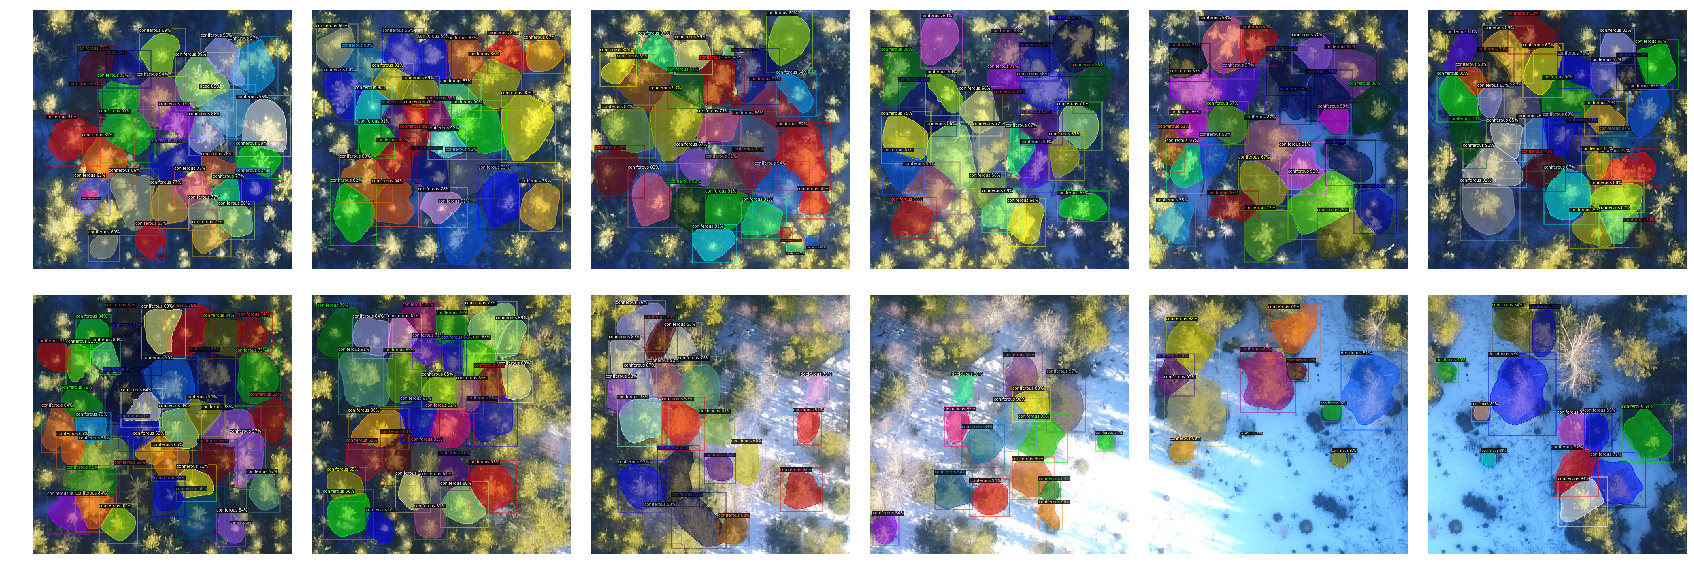

In [22]:
h = 10
fig, axes = plt.subplots(2,6, figsize=(3*h,h))
fig.subplots_adjust(hspace=.1, wspace=0)
i = 334
for ax in axes.ravel():
    dic = data[i]
    img = cv2.imread(dic["file_name"])
    predictions = predictor(img)
    visualizer = Visualizer(img, metadata=metadata) # instance_mode=ColorMode.IMAGE_BW
    vis = visualizer.draw_instance_predictions(predictions["instances"].to("cpu")).get_image()
    ax.imshow(vis)
    ax.set_axis_off()
    i += 1
# plt.savefig('poster_demo.png')

In [23]:
dic = data[334]
img = cv2.imread(dic["file_name"])
predictions = predictor(img)

In [83]:
mask = Visualizer(img, metadata=metadata).draw_instance_predictions(predictions["instances"].to("cpu")).get_image()

In [20]:
import matplotlib.pyplot as plt

In [9]:
dic["file_name"]

'/home/ubuntu/RGBD-Tree-Segs/test/CPT2a-n/tile_113.png'

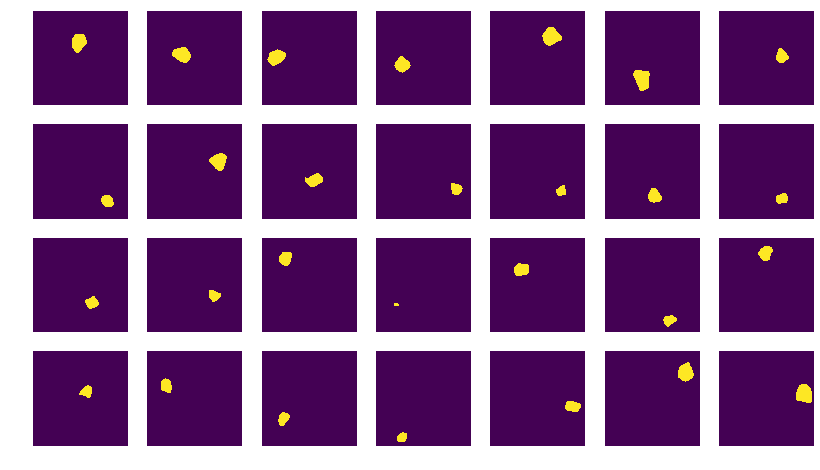

In [24]:
masks = predictions['instances'].pred_masks.cpu().numpy()
fig, axes = plt.subplots(4,7,figsize=(14,8))
for ax, mask in zip(axes.ravel(), masks):
    ax.imshow(mask)
    ax.set_axis_off()

In [25]:
mask = predictions['instances'].pred_masks.cpu().numpy()[0]
masks = np.where(mask==False,0,1)

for mask in predictions['instances'].pred_masks.cpu().numpy()[1:]:
    masks += np.where(mask==False,0,1)

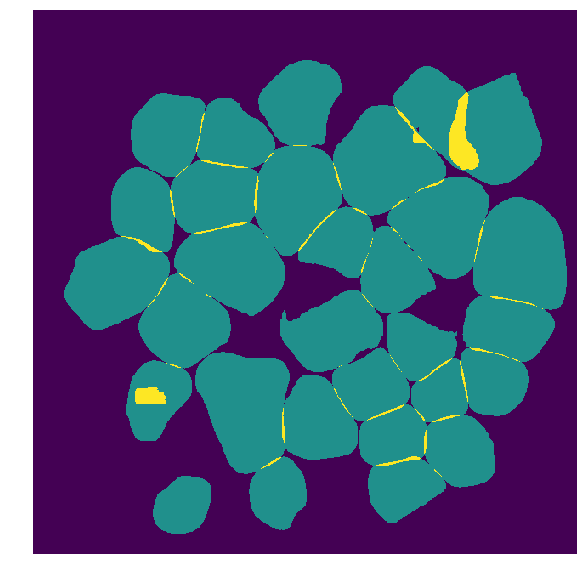

In [26]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.imshow(masks)
ax.set_axis_off()

masks

In [27]:
with open('m.json', 'w') as f:
    f.write(json.dumps([[float(y) for y in x] for x in masks]))

<module 'json' from '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/json/__init__.py'>

In [28]:
s = [x['segmentation'] for x in dic['annotations']]
with open('seg.json', 'w') as f:
    f.write(json.dumps(s))

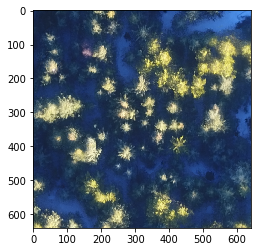

In [14]:
img = cv2.imread(dic["file_name"])
plt.imshow(img)

In [29]:
dic["file_name"]

'/home/ubuntu/RGBD-Tree-Segs/train/CPT2a-n/tile_334.png'

In [30]:
m=np.where(predictions['instances'].pred_masks.cpu().numpy()[0]==False,0.,1.)

In [37]:
with open('om.json','w') as f:
    f.write(json.dumps(m.tolist()))

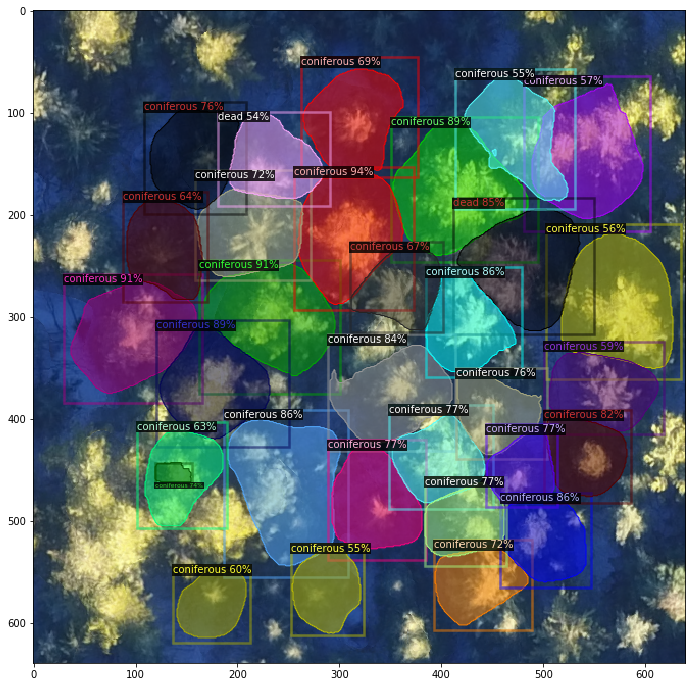

In [44]:
plt.figure(figsize=(12,12))
predictions = predictor(img)
visualizer = Visualizer(img, metadata=metadata) # instance_mode=ColorMode.IMAGE_BW
vis = visualizer.draw_instance_predictions(predictions["instances"].to("cpu")).get_image()
plt.imshow(vis)



In [6]:
import os
from glob import glob
import json

import cv2
import numpy as np
import shapefile

from detectron2.utils.visualizer import GenericMask

In [42]:
class Untiler:
    def __init__(self, predictor, path_to_tiles: str, output: str):
        self._predictor = predictor
        self.output = output
        self._tree_id = 0
        self._path_to_tiles = path_to_tiles
        with open(os.path.join(self._path_to_tiles, 'offsets.json'), 'r') as f:
            self.offsets = json.loads(f.read())

    def __call__(self, *args, **kwargs):

        tiles = glob(os.path.join(self._path_to_tiles, "*.png"))

        with shapefile.Writer(self.output) as shp:
            shp.shapeType = 5  # set shapetype to polygons
            shp.field('treeID', 'N', 24, 15)
            shp.field('polyArea', 'N', 24, 15)
            shp.field('segClass', 'C', 80, 0)

            x_scale, y_scale = self.offsets['transform']

            for tile in tiles:
                img = cv2.imread(tile, cv2.IMREAD_UNCHANGED)
                width, height = img.shape[1], img.shape[0]
                # TODO: implement
                x_shift, y_shift = self.offsets[os.path.realpath(tile)]
                predictions = self._predictor(img)
                predictions = predictions["instances"].to("cpu")
                if predictions.has("pred_masks"):
                    for (polygon, area, cls) in format_predictions(predictions, height, width):
                        shp.poly(affine_polygon(polygon, x_scale, y_scale, x_shift, y_shift))
                        # TODO: is class the id number or the string????????
                        shp.record(self._tree_id, area * x_scale * y_scale, cls)
                        self._tree_id += 1


def affine_polygon(polygon, x_scale, y_scale, x_shift, y_shift):
    """
    x and y scale -> should be inverse of scaling used to tile.
    shift in shapefile coordinates
    """
#     rescale_x = lambda x: (x * x_scale + x_shift)
#     rescale_y = lambda y: (y * y_scale + y_shift)
#     # TODO: deal with nested polygons(i.e. holes)?
#     rescaled_poly = [[rescale_x(x), rescale_y(y)] for x, y in polygon]
    x, y = polygon.transpose()
    return [np.array([x * x_scale + x_shift, y * y_scale + y_shift]).transpose()]


def format_predictions(predictions, height, width):
    masks = np.asarray(predictions.pred_masks)
    masks = [GenericMask(mask, height, width) for mask in masks]
    # polygon should not have holes (len(poly) = 1)
    polygons = [reshape_and_close_poly(mask.polygons[0]) for mask in masks]
    # boxes = predictions.pred_boxes if predictions.has("pred_boxes") else [mask.bbox() for mask in masks]
    classes = predictions.pred_classes if predictions.has("pred_classes") else [None for _ in masks]
    areas = [mask.area() for mask in masks]

    assert (len(polygons) == len(classes) == len(areas))

    return zip(polygons, areas, classes)

def reshape_and_close_poly(poly):
    poly = np.append(poly, poly[0:2])
    return np.reshape(poly, (len(poly)//2, 2))

In [151]:
tiles = glob(os.path.join(self._path_to_tiles, "*.png"))

NameError: name 'self' is not defined

In [43]:
ut = Untiler(predictor, '../../RGBD-Tree-Segs-Clean/tiles/CPT2a-n', 'testshapefile/rgbd')

In [44]:
ut()

In [127]:
with open('../../RGBD-Tree-Segs-Clean/tiles/CPT2a-n/offsets.json', 'r') as f:
    of = json.loads(f.read())

In [155]:
imn = glob('../../RGBD-Tree-Segs-Clean/tiles/CPT2a-n/*2004.png')[0]
im = cv2.imread(imn)

In [65]:
get_info = lambda x: (x.pred_masks, x.pred_classes)
masks, classes = get_info(predictor(im)['instances'])

In [ ]:
masks = np.asarray(masks)
masks = [GenericMask(mask, height, width) for mask in masks]

polygons = [mask.mask_to_polygons(mask) for mask in masks]

# boxes = predictions.pred_boxes if predictions.has("pred_boxes") else [mask.bbox() for mask in masks]
classes = predictions.pred_classes if predictions.has("pred_classes") else [None for _ in masks]
areas = [mask.sum() for mask in masks]

assert (len(polygons) == len(classes) == len(areas))

In [158]:
masks = predictor(im)['instances'].pred_masks.cpu()

In [160]:
masks = np.asarray(masks)

In [162]:
masks = [GenericMask(mask, 640, 640) for mask in masks]

In [174]:
masks[0].has_holes

False

In [46]:
import rasterio